#PyTDA Demo

<b>Author</b><br>
Timothy Lang, NASA MSFC<br>
timothy.j.lang@nasa.gov

<b>Overview</b><br>
PyTDA is a Python module that allows the use to estimate eddy dissipation rate (a measure of turbulence) from Doppler weather radar data. It interfaces seamlessly with Py-ART to make this calculation as simple as one line of code.

To get started, you need the following to be installed:
<ul>
<li>Py-ART (https://github.com/ARM-DOE/pyart)
<li>Standard python libraries like numpy, sklearn, scipy, Cython, etc.
</ul>

PyTDA is currently a pseudo-package, so you need to add the code location to your PYTHONPATH. Then you need to compile the Cython code using the provided compile_pytda_cython_code.sh script. Then you should be good to go for using this demo. PyTDA is tested and works under Python 2.7 and Python 3.4. If you switch between the two, you need to recompile the Cython code and recreate the shared object file after doing so.

In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pyart
import pytda
%matplotlib inline

So PyTDA is very simple to use. First you need a Py-ART radar object:

In [2]:
files = glob.glob('*.uf')
print(files)
radar = pyart.io.read(files[0])

['20101026_151323_KGWX_v284_SUR.uf']


Once you have that, send the radar object as an argument to the desired PyTDA function. There are two: calc_turb_sweep and calc_turb_vol. The former returns the turbulence field as an ndarray. The latter just successively calls the former to process a volume and modify the radar object and add the turbulence field. Currently, PyTDA only works on PPI sweeps/volumes.

In [3]:
pytda.calc_turb_vol(radar, verbose=True)

Sweep number: 0
0.1291952133178711 seconds to complete all preliminary processing
0.8122529983520508 seconds to compute longitudes and precompute Csnr, Crng, Czh
3.924175977706909 seconds to get eps, reduce data, compute BallTree, and get Cswv
i = 0 of 75824 7.009506225585938e-05 seconds elapsed during loop
i = 50000 of 75824 1.723844051361084 seconds elapsed during loop
7.465226173400879 seconds to process radar sweep
Sweep number: 1
0.13617205619812012 seconds to complete all preliminary processing
0.8213591575622559 seconds to compute longitudes and precompute Csnr, Crng, Czh
4.005435943603516 seconds to get eps, reduce data, compute BallTree, and get Cswv
i = 0 of 81375 8.606910705566406e-05 seconds elapsed during loop
i = 50000 of 81375 1.7030940055847168 seconds elapsed during loop
7.752629995346069 seconds to process radar sweep
Sweep number: 2
0.13618683815002441 seconds to complete all preliminary processing
0.8056907653808594 seconds to compute longitudes and precompute Csnr,

/Users/tjlang/Documents/Python/pytda/pytda.py:269: RuntimeWarning: invalid value encountered in sqrt
  turb_radar_f[i] = np.sqrt(num/tot)


The default is to do fuzzy-logic-based QC on the turbulence retrievals, to ensure better quality. This is like what the NCAR turbulence Detection Algorithm (NTDA) does. However, there is an option to turn that off and just have straight inversion of spectrum width to EDR. You can use the verbose keyword to turn off the text, I just turned it on to show more of what was going on. See the documentation below to find out all the different keyword options.

That's about it to do the processing. Usually takes about a minute or two per volume. Now let's use Py-ART to plot the results! First, let's define a function to do easy multi-panel plots in Py-ART.

In [6]:
def plot_list_of_fields(radar, sweep=0, fields=['reflectivity'], vmins=[0],
                        vmaxs=[65], units=['dBZ'], cmaps=['RdYlBu_r'],
                        return_flag=False, xlim=[-150, 150], ylim=[-150, 150],
                        mask_tuple=None):
    num_fields = len(fields)
    if mask_tuple is None:
        mask_tuple = []
        for i in np.arange(num_fields):
            mask_tuple.append(None)
    nrows = (num_fields + 1) // 2
    ncols = (num_fields + 1) % 2 + 1
    fig = plt.figure(figsize=(14.0, float(nrows)*5.5))
    display = pyart.graph.RadarDisplay(radar)
    for index, field in enumerate(fields):
        ax = fig.add_subplot(nrows, 2, index+1)
        display.plot_ppi(field, sweep=sweep, vmin=vmins[index],
                         vmax=vmaxs[index],
                         colorbar_label=units[index], cmap=cmaps[index],
                         mask_tuple=mask_tuple[index])
        display.set_limits(xlim=xlim, ylim=ylim)
    plt.tight_layout()
    if return_flag:
        return display

And now let's plot.

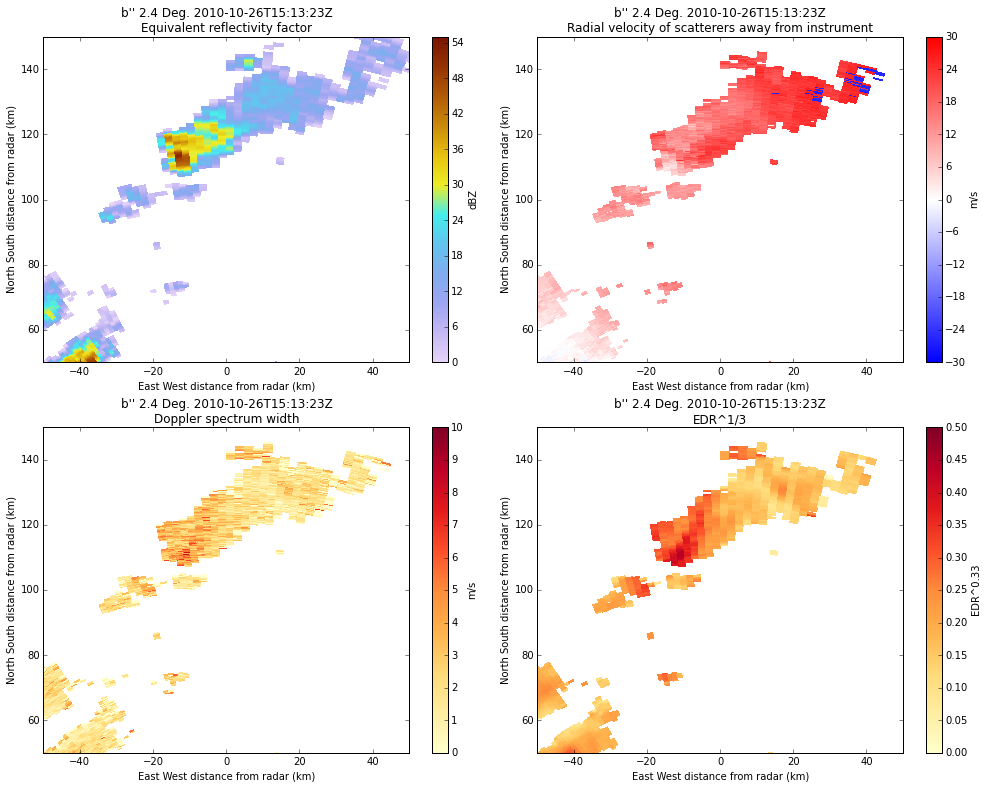

In [7]:
plot_list_of_fields(radar, sweep=4, fields=['reflectivity', 'velocity', 
                                            'spectrum_width', 'turbulence'],
                    vmins=[0, -30, 0, 0], vmaxs=[55, 30, 10, 0.5], 
                    units=['dBZ', 'm/s', 'm/s', 'EDR^0.33'],
                    cmaps=['pyart_LangRainbow12', 'bwr', 'YlOrRd', 'YlOrRd'],
                    xlim=[-50, 50], ylim=[50, 150])

In [9]:
help(pytda)

Help on module pytda:

NAME
    pytda

DESCRIPTION
    Python Turbulence Detection Algorithm (PyTDA)
    Version 0.9
    Last Updated 08/03/2015
    
    
    Major References
    ----------------
    Bohne, A. R. (1982). Radar detection of turbulence in precipitation
        environments. Journal of the Atmospheric Sciences, 39(8), 1819-1837.
    Doviak, R. J., and D. S. Zrnic, 1993: Doppler Radar and Weather Observations,
        Academic Press, 562 pp.
    Labitt, M. (1981). Coordinated radar and aircraft observations of turbulence
        (No. ATC-108). Federal Aviation Administration, Systems Research and
        Development Service.
    Williams, J. K., L. B. Cornman, J. Yee, S. G. Carson, G. Blackburn, and
        J. Craig, 2006: NEXRAD detection of hazardous turbulence. 44th AIAA
        Aerospace Sciences Meeting and Exhibit, Reno, NV.
    
    
    Author
    ------
    Timothy James Lang
    timothy.j.lang@nasa.gov
    (256) 961-7861
    
    
    Overview
    --------
    T